In [170]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import dotenv
dotenv.load_dotenv()

True

In [172]:
loc = 'nw2'
turbine = 'c02'
mode = 'SS2'
direction = 'ss'
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')

In [173]:
test_data_path = '_'.join([loc, turbine, mode, 'test_data.parquet'])
test_turbine_data = pd.read_parquet(os.path.join(data_folder, 'raw', loc, test_data_path))
#remove duplicated index
duplicated_indices = test_turbine_data.index.duplicated(keep='first')
test_turbine_data = test_turbine_data[~duplicated_indices]
test_turbine_data.index = pd.to_datetime(test_turbine_data.index, utc=True)

wandelaar_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_wandelaar_weather_data.parquet'))
westhinder_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_westhinder_weather_data.parquet'))

mvbc_test_data = wandelaar_weather_station_data.copy()
mvbc_test_data[mvbc_test_data.filter(regex='Tide').columns] = westhinder_weather_station_data.filter(regex='Tide').values
#mvbc_test_data.rename(columns={mvbc_test_data.filter(regex='Tide').columns[0] :westhinder_weather_station_data.filter(regex='Tide').columns[0]}, inplace=True)
mvbc_test_data.isna().sum()
mvbc_test_data.index = pd.to_datetime(mvbc_test_data.index, utc=True)

In [174]:
from src.data.preprocessing import sin_cos_angle_inputs
selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature']
test_turbine_data_transformed = sin_cos_angle_inputs(test_turbine_data)
input_data = pd.concat([test_turbine_data_transformed, mvbc_test_data], axis=1)[selected_columns]

input_data.to_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'input.parquet'))

In [175]:
mpe_direction = \
        pd.DataFrame.from_records(
            test_turbine_data['mpe_'+loc.upper()+'_'+turbine.upper()+'_'+direction.upper()].explode().dropna().tolist(),
            index=test_turbine_data['mpe_'+loc.upper()+'_'+turbine.upper()+'_'+direction.upper()].explode().dropna().index,
            )

lower_freq = 0.98
upper_freq = 1.08
ss2 = mpe_direction[(mpe_direction['mean_frequency'] < upper_freq) & (mpe_direction['mean_frequency'] > lower_freq)]
ss2.to_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'ss2.parquet'))

In [176]:
mode_frequency_ = ss2['mean_frequency']
inputs_ = input_data.copy()
y = mode_frequency_.dropna()
X = inputs_.loc[y.index].dropna()
y = y.loc[X.index]

In [177]:
import pickle
models_folder = os.path.join(package_folder, 'models', loc)
model_path = os.path.join(models_folder, 'catboost_model_large.pkl')
with open(model_path, 'rb') as file:
    regr_model = pickle.load(file)

In [178]:
# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

# uncertainty = knowledge_uncertainty + data_uncertainty
uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()

# save the predictions
predictions_df.to_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'predictions.parquet'))
virtual_ensemble_preds_df.to_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'virtual_ensemble_predictions.parquet'))

In [180]:
from src.smart_tracking.smart_tracking import smart_tracking
uncertainty_lim = 5.902143777376365e-07 #1.199509060664933e-06 #4.5327128643510377e-07

prediction_lim = 0.013929963833652415 #0.03366844053166324 0.041789891500957244 #

smart_tracked_modes = smart_tracking(y, predictions_df['prediction'], uncertainty_moving_avg, uncertainty_lim, prediction_lim)
smart_tracked_modes.to_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'smart_tracked_modes.parquet'))

In [181]:
from src.data.utils import get_input_data
from src.data.harmonics import *

harmonics_data = harmonics(test_turbine_data.filter(regex='rpm'), [1,3,6, 9])

C:\Users\Max\AppData\Local\Temp\ipykernel_2548\986008205.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_2548\986008205.py:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


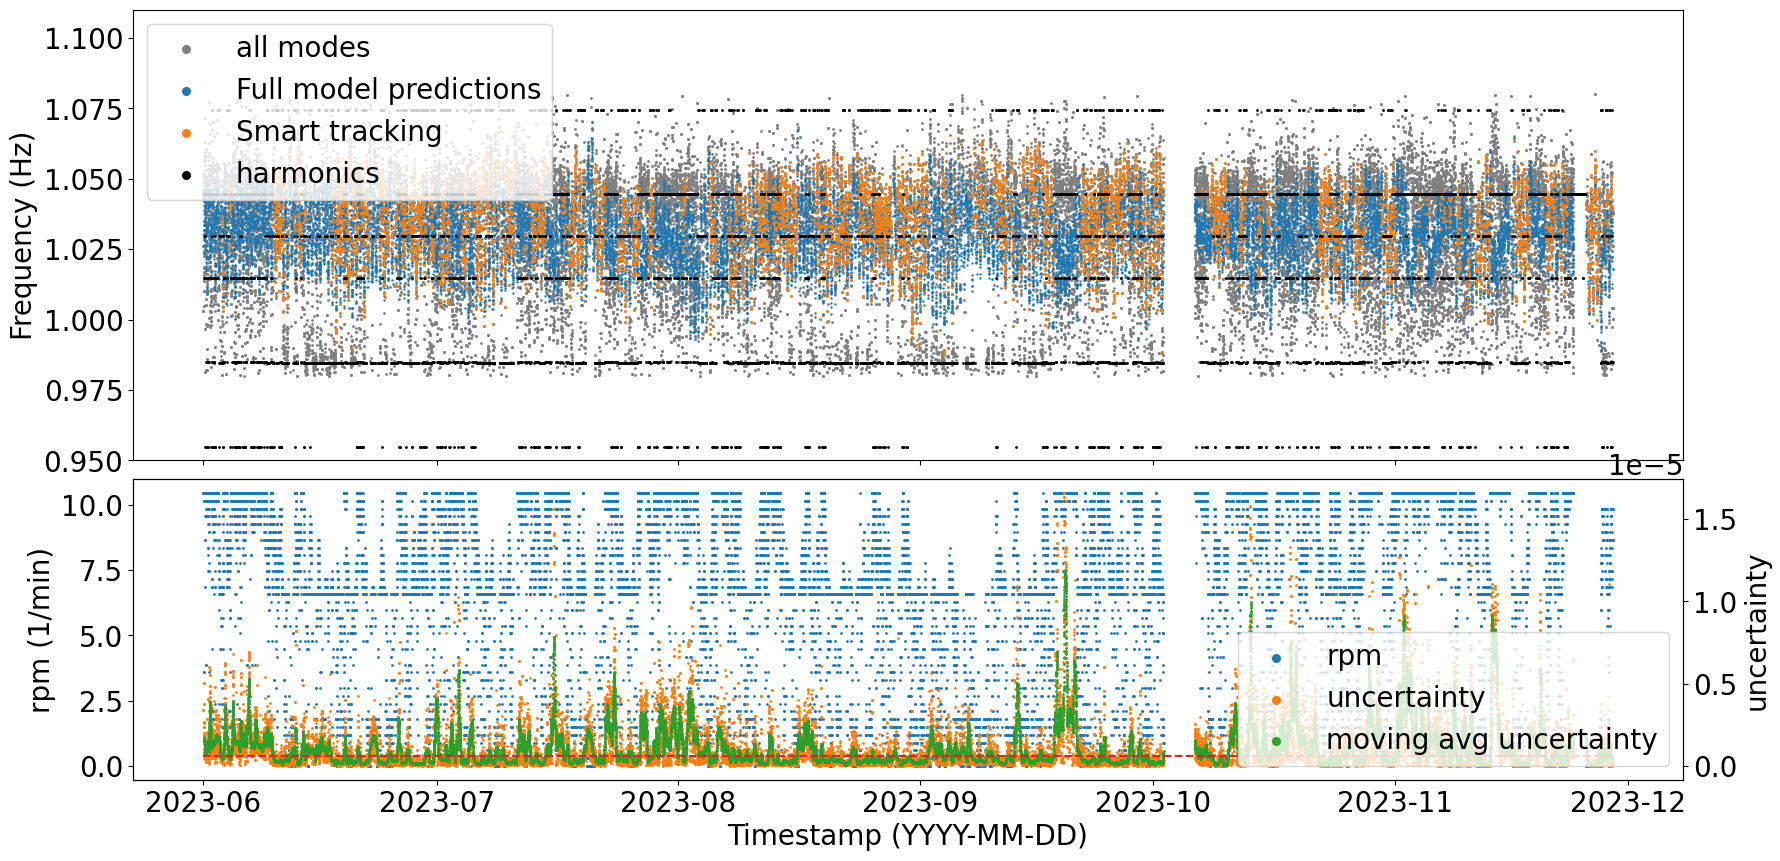

In [182]:
import matplotlib.pyplot as plt
import datetime

# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=0.5, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:orange', label='Smart tracking')
for harmonic in harmonics_data.columns:
    ax1.scatter(harmonics_data.index, harmonics_data[harmonic], color='k', s=1)

#ax1.plot(harmonics_data, color='k', linestyle='--', linewidth=0.5, label='harmonics')
#ax1.scatter(y_train.index, y_train, s=3, color='tab:blue', label='training data')
#ax1.scatter(y.index, predicted_value, s=2, color='tab:orange', label='Full model predictions')


#ax1.scatter(y.index, virtual_ensemble_preds_mean, s=2, color='tab:green', label='Virtual ensemble mean predictions')

ax1.set_ylim(0.95, 1.11)
legend1 = ax1.legend(loc='upper left', labels = ['all modes', 'Full model predictions', 'Smart tracking', 'harmonics']) 
for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')


# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')
#ax2.scatter(X.index, data_uncertainty, label='data uncertainty', s=1, color='tab:blue')
#ax2.set_ylim(0, 1e-5)

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
#ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed

plt.show()
plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_2548\3272265698.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_2548\3272265698.py:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


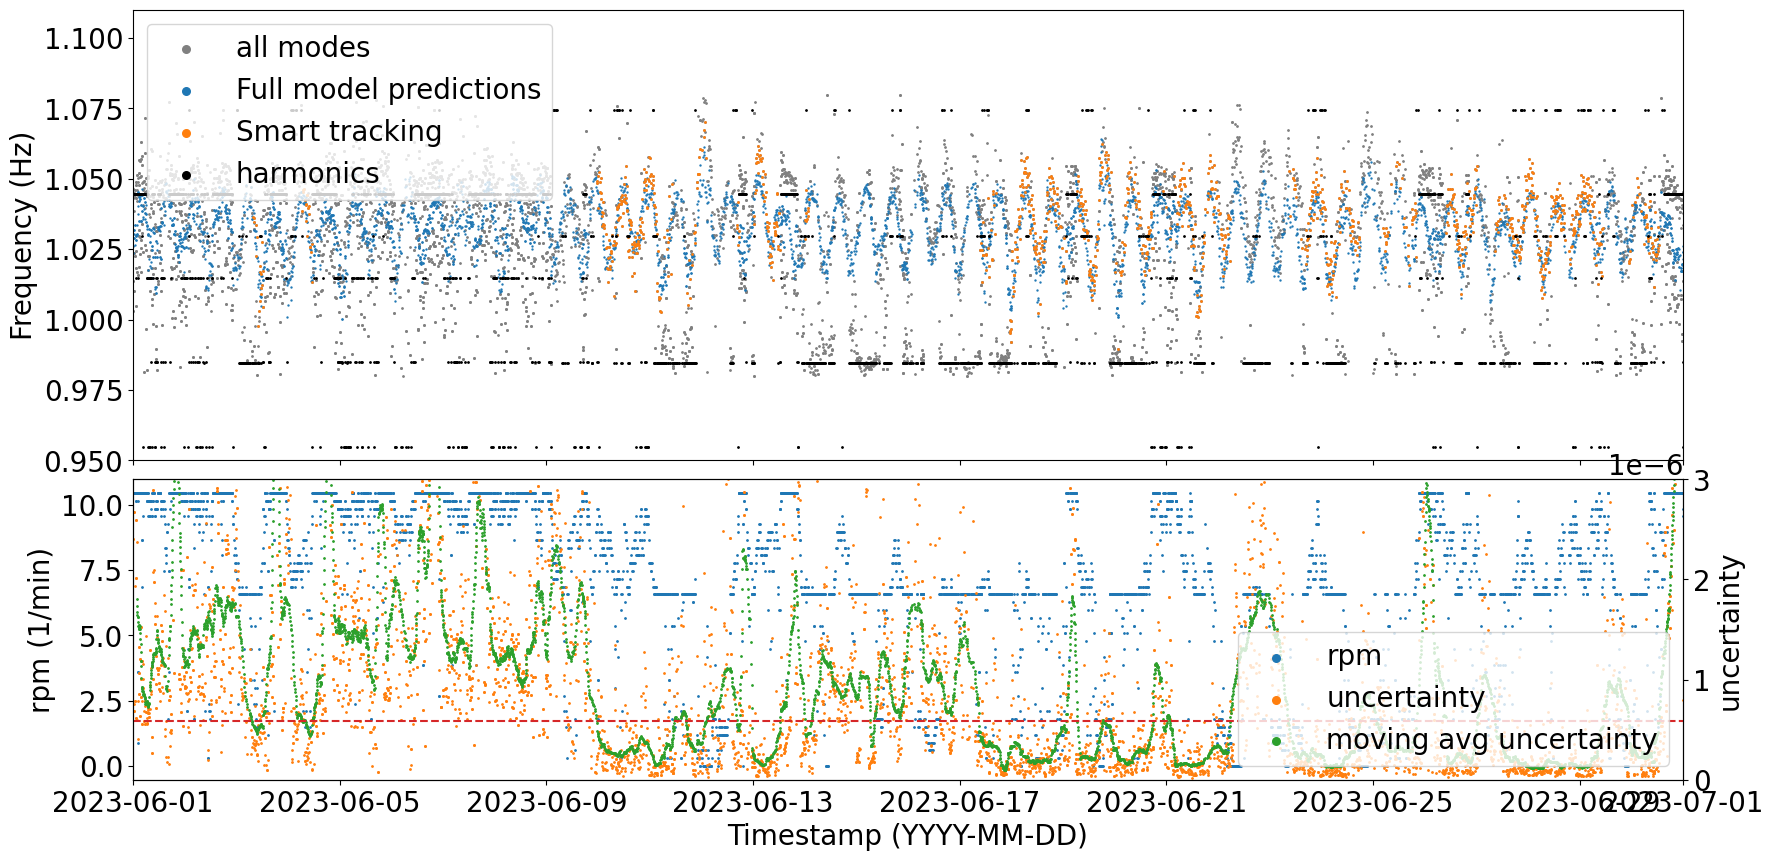

In [183]:
import matplotlib.pyplot as plt
import datetime

# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=0.5, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:orange', label='Smart tracking')
for harmonic in harmonics_data.columns:
    ax1.scatter(harmonics_data.index, harmonics_data[harmonic], color='k', s=1)

#ax1.plot(harmonics_data, color='k', linestyle='--', linewidth=0.5, label='harmonics')
#ax1.scatter(y_train.index, y_train, s=3, color='tab:blue', label='training data')
#ax1.scatter(y.index, predicted_value, s=2, color='tab:orange', label='Full model predictions')


#ax1.scatter(y.index, virtual_ensemble_preds_mean, s=2, color='tab:green', label='Virtual ensemble mean predictions')

ax1.set_ylim(0.95, 1.11)
legend1 = ax1.legend(loc='upper left', labels = ['all modes', 'Full model predictions', 'Smart tracking', 'harmonics'])
for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')


# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')
#ax2.scatter(X.index, data_uncertainty, label='data uncertainty', s=1, color='tab:blue')
#ax2.set_ylim(0, 1e-5)

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.xlim(datetime.datetime(2023, 6, 1, 0, 0, tzinfo=utc), datetime.datetime(2023, 7, 1, tzinfo=utc))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed


plt.show()
plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_2548\2537148679.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_2548\2537148679.py:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


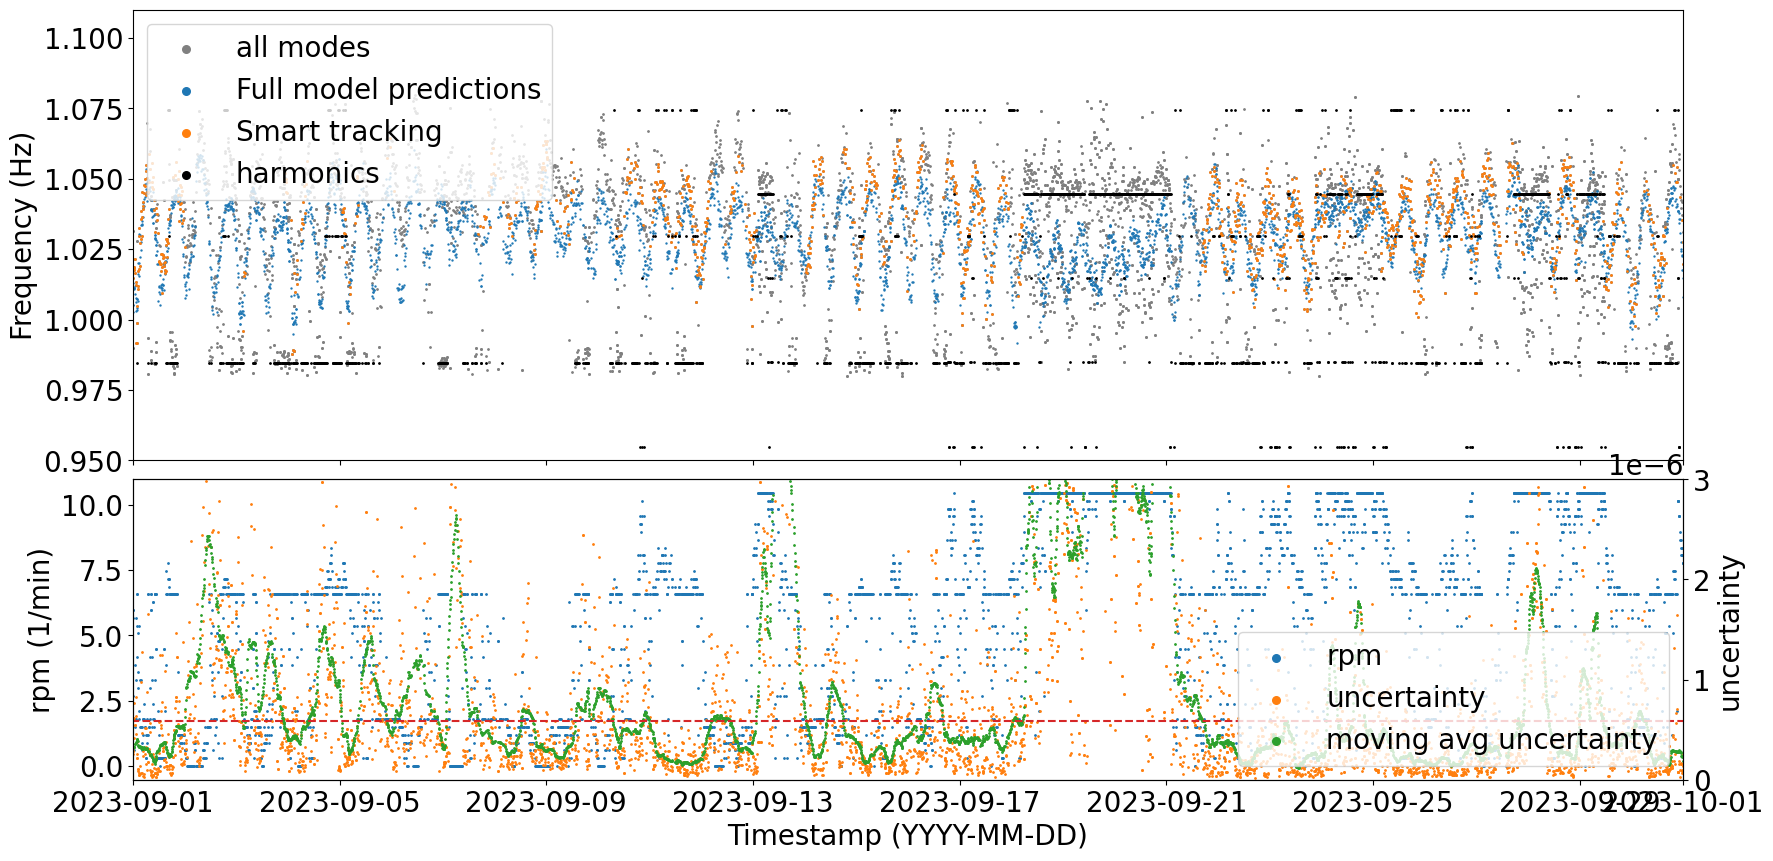

In [184]:
import matplotlib.pyplot as plt
import datetime

# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=0.5, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:orange', label='Smart tracking')
for harmonic in harmonics_data.columns:
    ax1.scatter(harmonics_data.index, harmonics_data[harmonic], color='k', s=1)

#ax1.plot(harmonics_data, color='k', linestyle='--', linewidth=0.5, label='harmonics')
#ax1.scatter(y_train.index, y_train, s=3, color='tab:blue', label='training data')
#ax1.scatter(y.index, predicted_value, s=2, color='tab:orange', label='Full model predictions')


#ax1.scatter(y.index, virtual_ensemble_preds_mean, s=2, color='tab:green', label='Virtual ensemble mean predictions')

ax1.set_ylim(0.95, 1.11)
legend1 = ax1.legend(loc='upper left', labels = ['all modes', 'Full model predictions', 'Smart tracking', 'harmonics'])
for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')


# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')
#ax2.scatter(X.index, data_uncertainty, label='data uncertainty', s=1, color='tab:blue')
#ax2.set_ylim(0, 1e-5)

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.xlim(datetime.datetime(2023, 9, 1, 0, 0, tzinfo=utc), datetime.datetime(2023, 10, 1, tzinfo=utc))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed


plt.show()
plt.close()

In [185]:
df_predictions

NameError: name 'df_predictions' is not defined

In [ ]:
X_smart_tracked = X.loc[smart_tracked_modes.index]

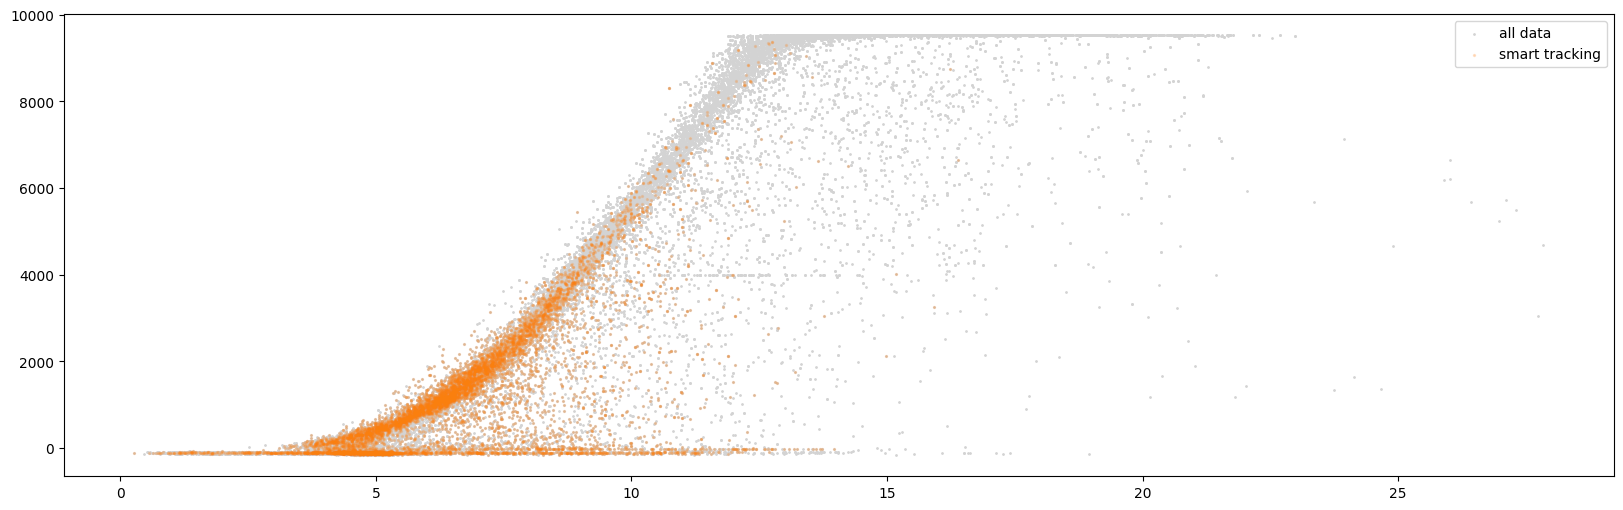

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(X.filter(regex='windspeed'), X.filter(regex='power'), color='lightgrey', s=1, label='all data')
plt.scatter(X_smart_tracked.filter(regex='windspeed'), X_smart_tracked.filter(regex='power'), color='tab:orange', s=2, label='smart tracking', alpha=0.2)
plt.legend()
plt.show()
plt.close()

(30636, 1) (30636,)
(7872, 1) (7872, 1)


C:\Users\Max\AppData\Local\Temp\ipykernel_2548\3644458855.py:56: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handles in legend.legendHandles:


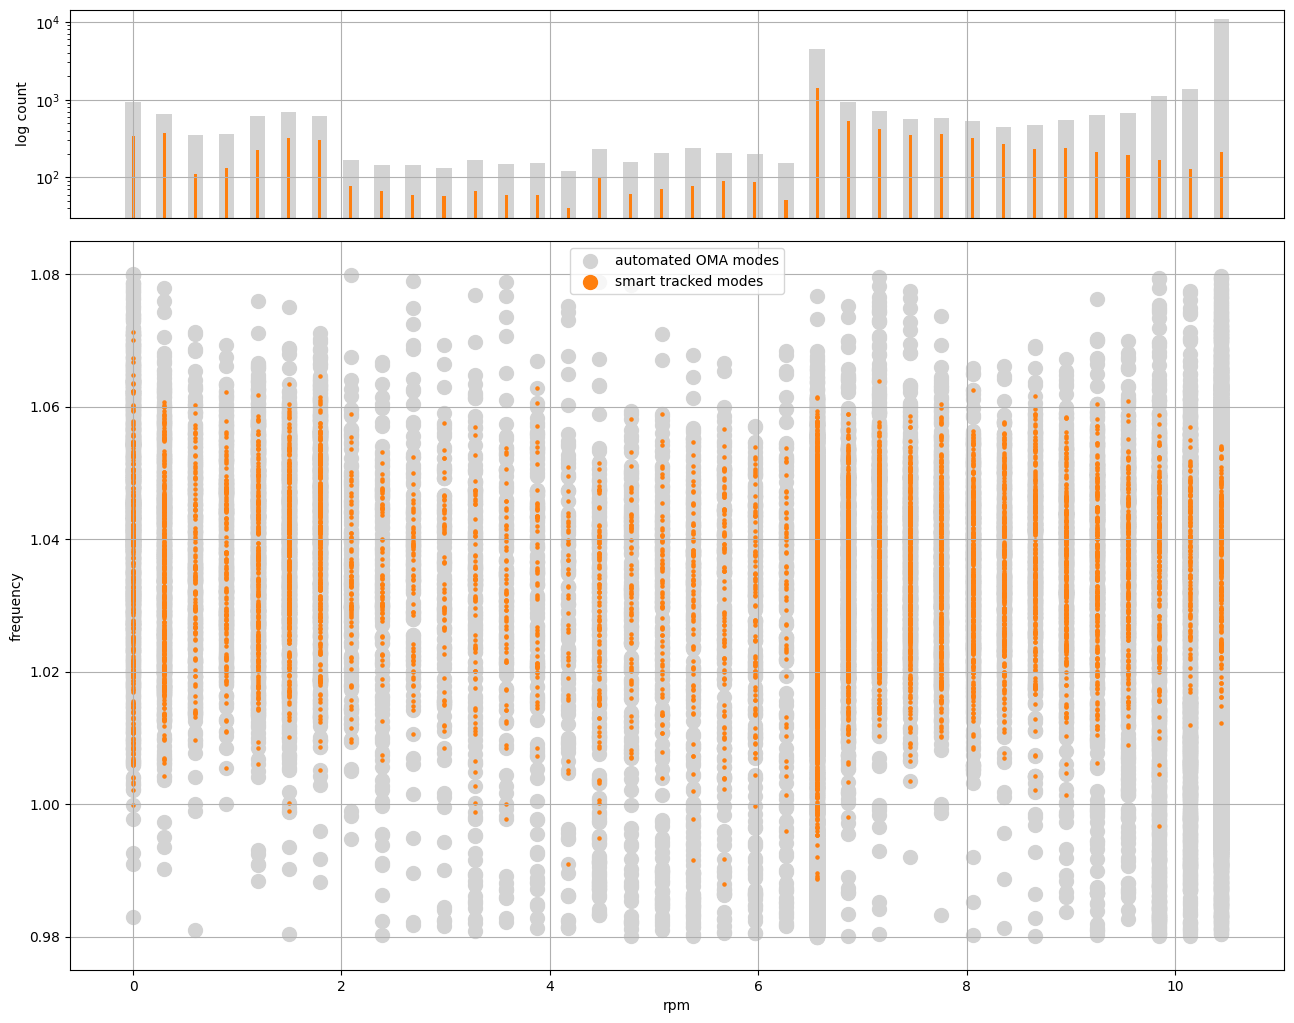

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def scatter_hist(x, y, ax, ax_histx, nr_bins=20, width_divider=2, color='tab:blue', **kwargs):
    # Scatter plot
    ax.scatter(x, y, color=color, **kwargs)

    # Calculate bin width based on the width_divider
    xbin_width = (x.values.max() - x.values.min()) / (width_divider*nr_bins)

    # Adjust start and end points to center bins
    xstart_point = x.values.min() - xbin_width / 2
    xend_point = x.values.max() + xbin_width / 2

    # Calculate bin edges
    x_bins = np.arange(xstart_point, xend_point + xbin_width, xbin_width)
    
    # Histogram on the attached axes
    ax_histx.hist(x, bins=x_bins, color=color)
    ax_histx.set_yscale('log')


# Set up the axes with gridspec
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
#ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
#Plt all data
x_ = X.filter(regex='rpm').copy()
y_ = mode_frequency_.copy()
y_ = y_.loc[y_.index.drop_duplicates(keep='first')]
x_ = x_.loc[x_.index.drop_duplicates(keep='first')]
common_indices = x_.index.intersection(y_.index)
x_ = x_.loc[common_indices]
y_ = y_.loc[common_indices]

print(x_.shape, y_.shape)
scatter_hist(x_, y_, ax, ax_histx, nr_bins=35, color='lightgrey', label='automated OMA modes', s=100)

x_ = X.loc[smart_tracked_modes.index].filter(regex='rpm').copy().reset_index()
y_ = smart_tracked_modes['frequency'].copy().reset_index()
y_ = y_.drop_duplicates(subset='timestamp', keep='first').set_index('timestamp')
x_ = x_.drop_duplicates(subset='timestamp', keep='first').set_index('timestamp')
common_indices = x_.index.intersection(y_.index)
x_ = x_.loc[common_indices]
y_ = y_.loc[common_indices]
print(x_.shape, y_.shape)
scatter_hist(x_, y_, ax, ax_histx, nr_bins=35, width_divider=10, label='smart tracked modes', color='tab:orange', s=5)

legend = ax.legend()
for handles in legend.legendHandles:
    handles.set_sizes([100.0])
ax_histx.grid()
ax_histx.set_ylabel('log count')
ax_histx.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.grid()
ax.set_xlabel('rpm')
ax.set_ylabel('frequency')

plt.show()
plt.close()


In [ ]:
y_.values

array([[1.03650817],
       [1.03459381],
       [1.03614991],
       ...,
       [1.04229202],
       [1.03714822],
       [1.02650708]])

NameError: name 'data_uncertainty_lim' is not defined

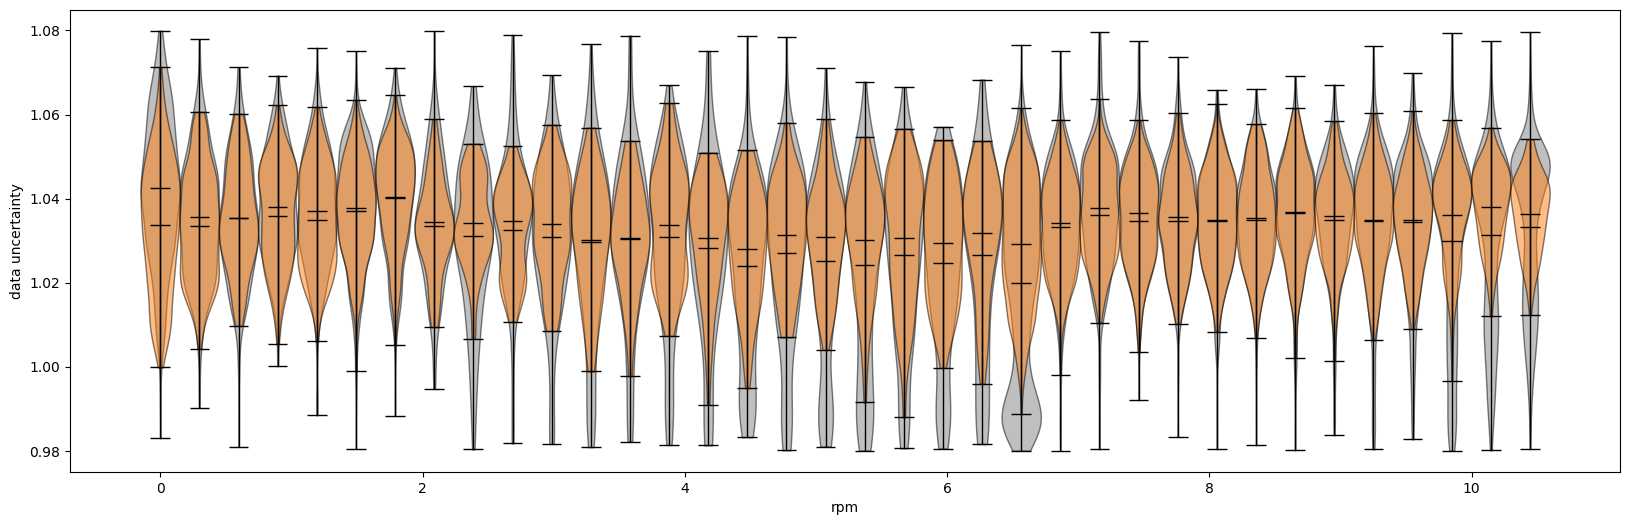

In [ ]:
x_ = X.filter(regex='rpm').copy()
y_ = mode_frequency_.copy()
y_ = y_.loc[y_.index.drop_duplicates(keep='first')]
x_ = x_.loc[x_.index.drop_duplicates(keep='first')]
common_indices = x_.index.intersection(y_.index)
x_ = x_.loc[common_indices]
y_ = y_.loc[common_indices]

violinplot_all_data = pd.DataFrame({'data uncertainty':y_.values, 'rpm':x_.values.flatten()})

x_ = X.loc[smart_tracked_modes.index].filter(regex='rpm').copy().reset_index()
y_ = smart_tracked_modes['frequency'].copy().reset_index()
y_ = y_.drop_duplicates(subset='timestamp', keep='first').set_index('timestamp')
x_ = x_.drop_duplicates(subset='timestamp', keep='first').set_index('timestamp')
common_indices = x_.index.intersection(y_.index)
x_ = x_.loc[common_indices]
y_ = y_.loc[common_indices]

violinplot_smart_tracked_data = pd.DataFrame({'data uncertainty':y_.values.flatten(), 'rpm':x_.values.flatten()})

rpms = np.unique(violinplot_all_data['rpm'])
plt.figure(figsize=(20,6))
for rpm in rpms:
    # Make a violinplot at the x value of the rpm width=0.5 # in a black color with mean in red
    violin = plt.violinplot(violinplot_all_data[violinplot_all_data['rpm']==rpm]['data uncertainty'], positions=[rpm], showmeans=True, widths=0.3)
    # Make a boxplot at the x value of the rpm


    #plt.violinplot(boxplot_data[boxplot_data['rpm']==rpm]['data uncertainty'], positions=[rpm], showmeans=True, widths=0.2, c='k')
    # Make a boxplot at the x value of the rpm
    #plt.boxplot(boxplot_data[boxplot_data['rpm']==rpm]['data uncertainty'], positions=[rpm])
    for pc in violin["bodies"]:
        pc.set_facecolor("grey")
        pc.set_edgecolor("black")
        pc.set_alpha(0.5)

    for partname in ('cbars', 'cmins', 'cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor("k")
        vp.set_linewidth(1)

    for partname in (['cmeans']):
        vp = violin[partname]
        vp.set_edgecolor("k")
        vp.set_linewidth(1)

    violin_smart_tracked = plt.violinplot(violinplot_smart_tracked_data[violinplot_smart_tracked_data['rpm']==rpm]['data uncertainty'], positions=[rpm], showmeans=True, widths=0.3)
    for pc in violin_smart_tracked["bodies"]:
        pc.set_facecolor("tab:orange")
        pc.set_edgecolor("black")
        pc.set_alpha(0.5)

    for partname in ('cbars', 'cmins', 'cmaxes'):
        vp = violin_smart_tracked[partname]
        vp.set_edgecolor("k")
        vp.set_linewidth(1)

    for partname in (['cmeans']):
        vp = violin_smart_tracked[partname]
        vp.set_edgecolor("k")
        vp.set_linewidth(1)



plt.ylabel('data uncertainty')
plt.xlabel('rpm')
plt.hlines(data_uncertainty_lim, 0, X.filter(regex='rpm').max(), color='red', linestyle='--')
# Only show one x tick every 5 ticks
plt.xticks(np.arange(11), np.arange(11))
plt.show()
plt.close()

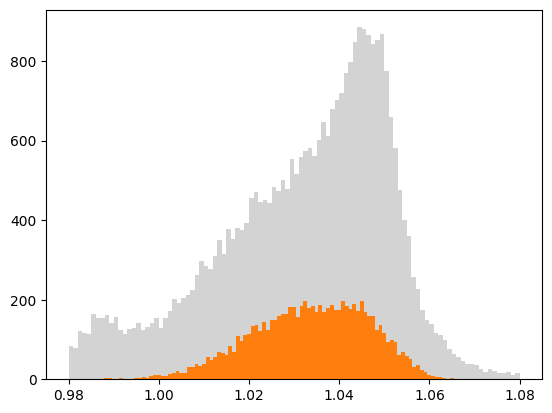

In [ ]:
hist_all = plt.hist(mode_frequency_, bins=100, label='all data', color='lightgrey')
hist_smart = plt.hist(smart_tracked_modes['frequency'], bins=100, label='all data', color='tab:orange')

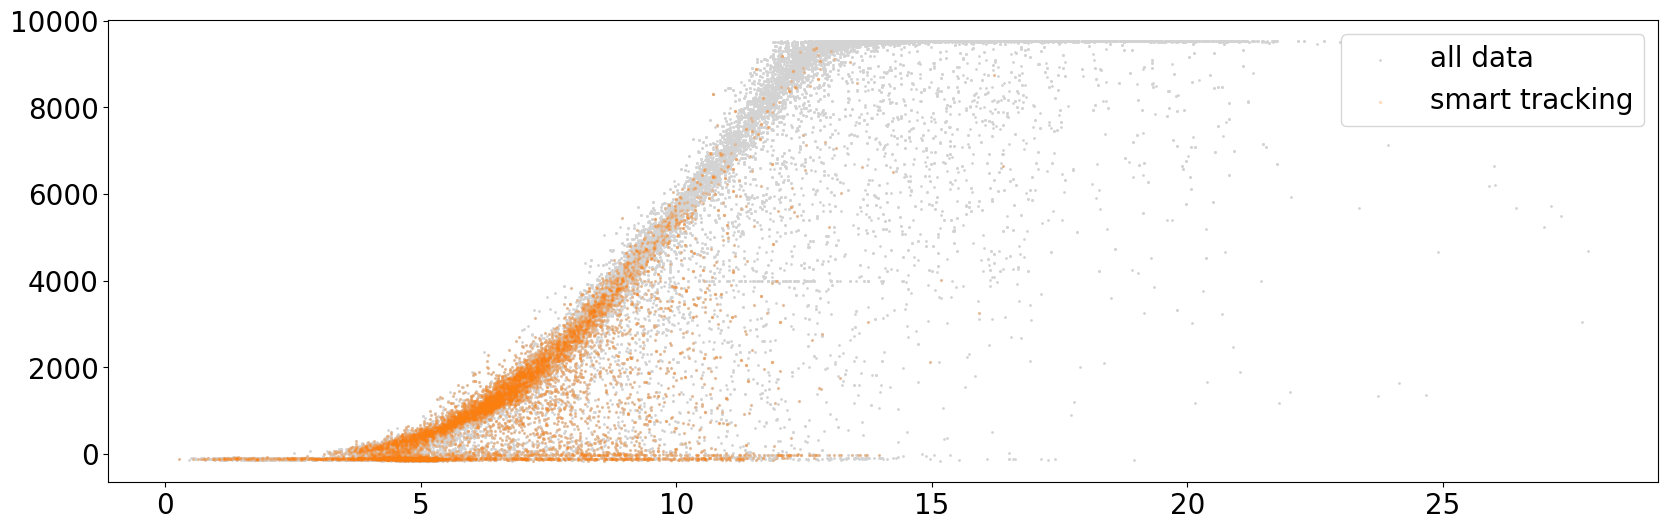

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(X.filter(regex='windspeed'), X.filter(regex='power'), color='lightgrey', s=1, label='all data')
plt.scatter(X_smart_tracked.filter(regex='windspeed'), X_smart_tracked.filter(regex='power'), color='tab:orange', s=2, label='smart tracking', alpha=0.2)
plt.legend()
plt.show()
plt.close()

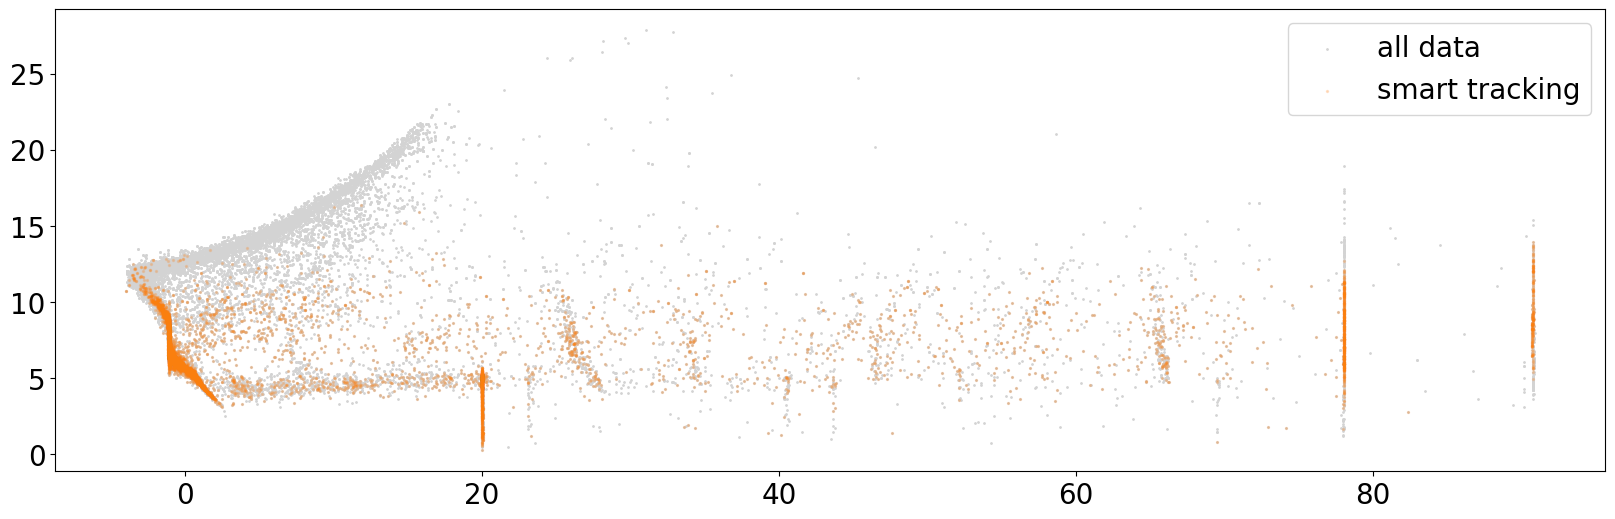

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(X.filter(regex='pitch'), X.filter(regex='windspeed'), color='lightgrey', s=1, label='all data')
plt.scatter(X_smart_tracked.filter(regex='pitch'), X_smart_tracked.filter(regex='windspeed'), color='tab:orange', s=2, label='smart tracking', alpha=0.2)
plt.legend()
plt.show()
plt.close()

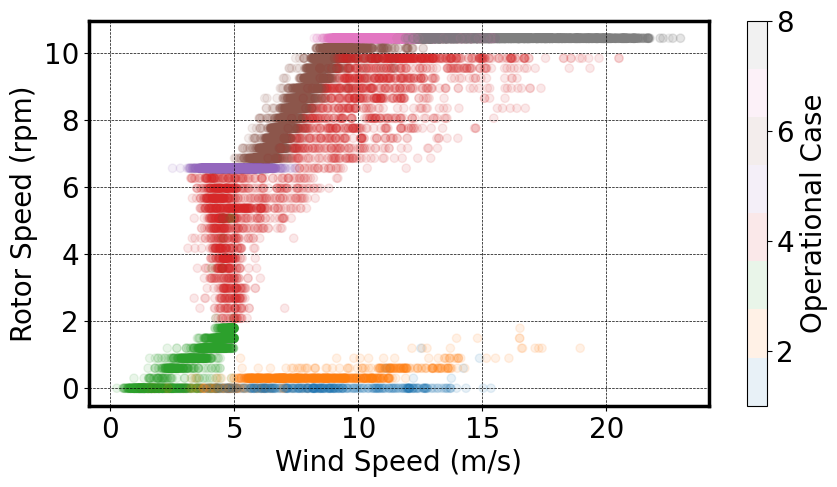

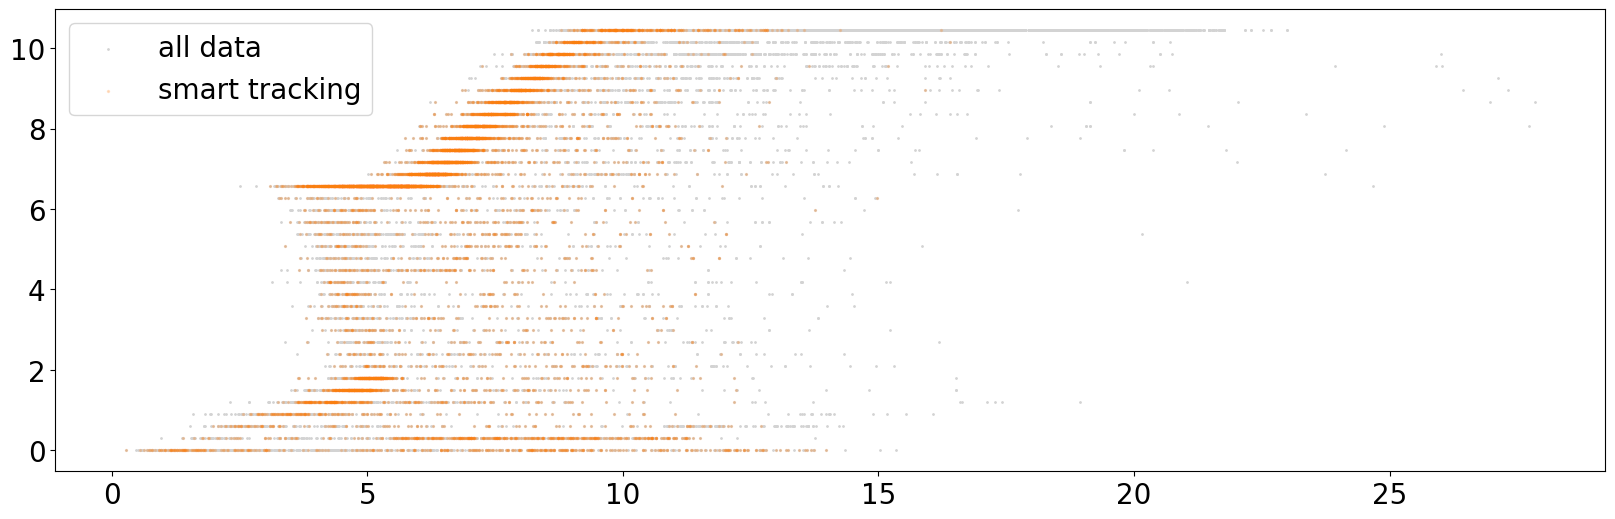

In [ ]:
### Multiple Linear Regression
# define the 6 operational cases
inputs = X.copy()
inputs['operational_case'] = np.nan

cutout_windspeed = 25
windspeed5 = 5
windspeed20 = 20
windspeed2_5 = 2.5
windspeed7_5 = 7.5
windspeed15_5 = 15.5

pitch_1 = -1
pitch19 = 19
pitch19_5 = 19.5
pitch20_5 = 20.5
pitch70 = 70
pitch80 = 80
pitch100 = 100
pitch_20 = -20
pitch1 = 1
pitch70 = 70

rpm2_5 = 2.5
rpm10 = 10
rpm2_05 = 2.05
rpm9_8 = 6.3
rpm10_2 = 6.8
rpm15_9 = 10.2
rpm17 = 17
rpm2_2 = 2.2

power2950 = 9000
power2920 = 9000

# Case 1: parked
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') <= rpm2_5).values[:,0] \
    & (inputs.filter(regex='pitch') >= pitch80).values[:,0] \
    & (inputs.filter(regex='pitch') <= pitch100).values[:,0],
    1,
    inputs['operational_case']
)

# Case 2: pitch:80
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') <= rpm2_5).values[:,0] \
    & (inputs.filter(regex='pitch') >= pitch70).values[:,0] \
    & (inputs.filter(regex='pitch') <= pitch80).values[:,0] \
    & (inputs.filter(regex='windspeed') <= windspeed20).values[:,0],
    2,
    inputs['operational_case']
)

# Case 3: pitch:20
inputs['operational_case'] = np.where(
    (inputs.filter(regex='pitch') >= pitch19_5).values[:,0] \
    & (inputs.filter(regex='pitch') <= pitch20_5).values[:,0] \
    & (inputs.filter(regex='windspeed') <= windspeed5).values[:,0],
    3,
    inputs['operational_case']
)

# Case 4: rpm<10
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') >= rpm2_05).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm10).values[:,0] \
    & (inputs.filter(regex='pitch') >= pitch_1).values[:,0] \
    & (inputs.filter(regex='pitch') <= pitch19).values[:,0],
    4,
    inputs['operational_case']
)

# Case 5: rpm:10
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') >= rpm9_8).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm10_2).values[:,0] \
    & (inputs.filter(regex='windspeed') >= windspeed2_5).values[:,0] \
    & (inputs.filter(regex='windspeed') <= windspeed7_5).values[:,0],
    5,
    inputs['operational_case']
)

# Case 6: rpm<16
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') >= rpm10_2).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm15_9).values[:,0] \
    & (inputs.filter(regex='pitch') > pitch_20).values[:,0] \
    & (inputs.filter(regex='pitch') < pitch1).values[:,0],
    6,
    inputs['operational_case']
)

# Case 7: Rated RPM
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') >= rpm15_9).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm17).values[:,0] \
    & (inputs.filter(regex='windspeed') <= windspeed15_5).values[:,0] \
    & (inputs.filter(regex='power') <= power2950).values[:,0],
    7,
    inputs['operational_case']
)

# Case 8: Rated Power
inputs['operational_case'] = np.where(
    (inputs.filter(regex='rpm') >= rpm15_9).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm17).values[:,0] \
    & (inputs.filter(regex='power') >= power2920).values[:,0],
    8,
    inputs['operational_case']
)

# Case 9: Cutout
inputs['operational_case'] = np.where(
    (inputs.filter(regex='pitch') > pitch70).values[:,0] \
    & (inputs.filter(regex='pitch') < pitch80).values[:,0] \
    & (inputs.filter(regex='windspeed') > windspeed20).values[:,0] \
    & (inputs.filter(regex='rpm') <= rpm2_2).values[:,0],
    9,
    inputs['operational_case']
)

operaional_case_names = {1: 'Parked', 2: 'Pitch:80', 3: 'Pitch:20', 4: 'RPM<6.4', 5: 'RPM:6.4', 6: 'RPM<10', 7: 'Rated RPM', 8: 'Rated Power', 9: 'Cutout'}

import matplotlib

plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(10, 5))
cmap = matplotlib.colors.ListedColormap(plt.cm.tab10.colors[:len(inputs['operational_case'].unique())-1])
plt.scatter(inputs.filter(regex='windspeed').values[:,0], inputs.filter(regex='rpm').values[:,0], alpha=0.1, c=inputs['operational_case'], cmap=cmap)
# Add the colorbar with alpha = 1
cbar = plt.colorbar()
cbar.ax.set_ylabel('Operational Case')
cbar.set_alpha(1)
#cbar.draw_all()
tick_locs = np.linspace(int(inputs['operational_case'].min()), int(inputs['operational_case'].max()), int(2 * len(inputs['operational_case'].unique()) -1 ))[1::2]
cbar_tick_label = np.arange(int(inputs['operational_case'].min()), int(inputs['operational_case'].max() + 1))
#cbar.set_ticks(tick_locs)
#cbar.set_ticklabels(cbar_tick_label)

# Increase the width of the spines
ax.spines['left'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['top'].set_linewidth(2.5)

plt.grid(True, color='k', linestyle='--', linewidth=0.5)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Rotor Speed (rpm)')
plt.show()
plt.figure(figsize=(20, 6))
plt.scatter(X.filter(regex='windspeed'), X.filter(regex='rpm'), color='lightgrey', s=1, label='all data')
plt.scatter(X_smart_tracked.filter(regex='windspeed'), X_smart_tracked.filter(regex='rpm'), color='tab:orange', s=2, label='smart tracking', alpha=0.2)
plt.legend()
plt.show()
plt.close()

1.0 Parked


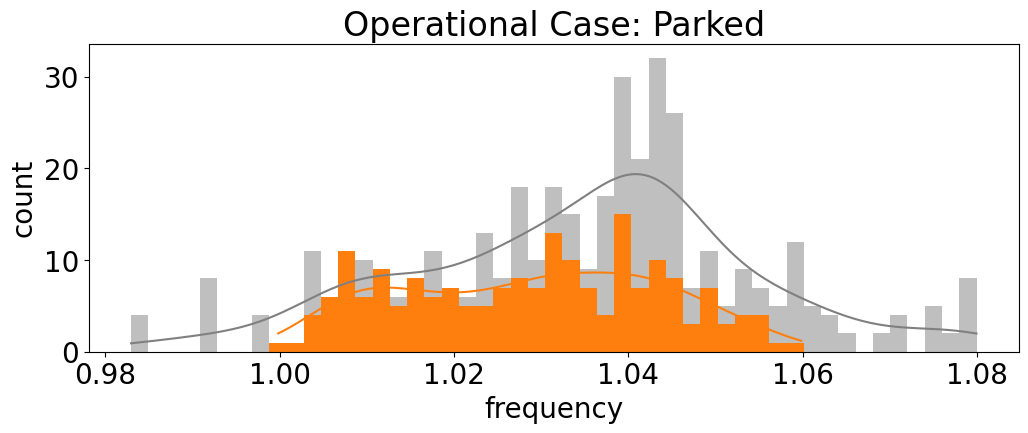

2.0 Pitch:80


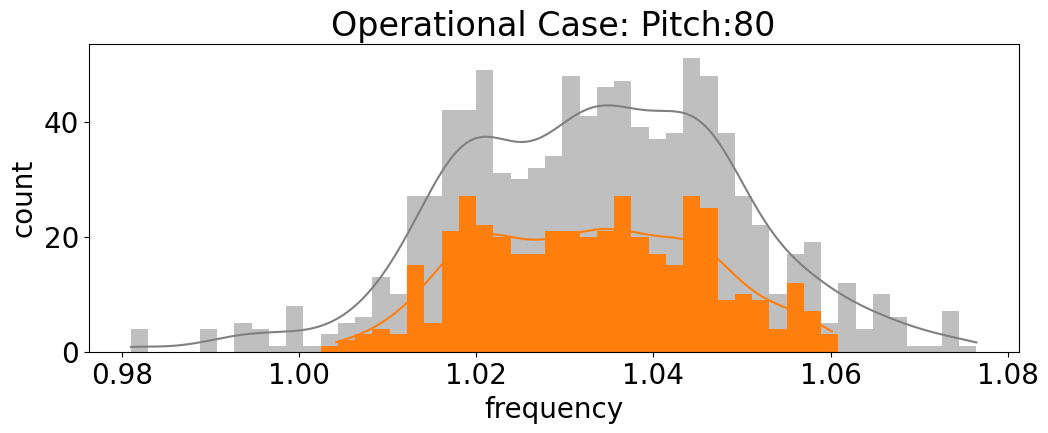

3.0 Pitch:20


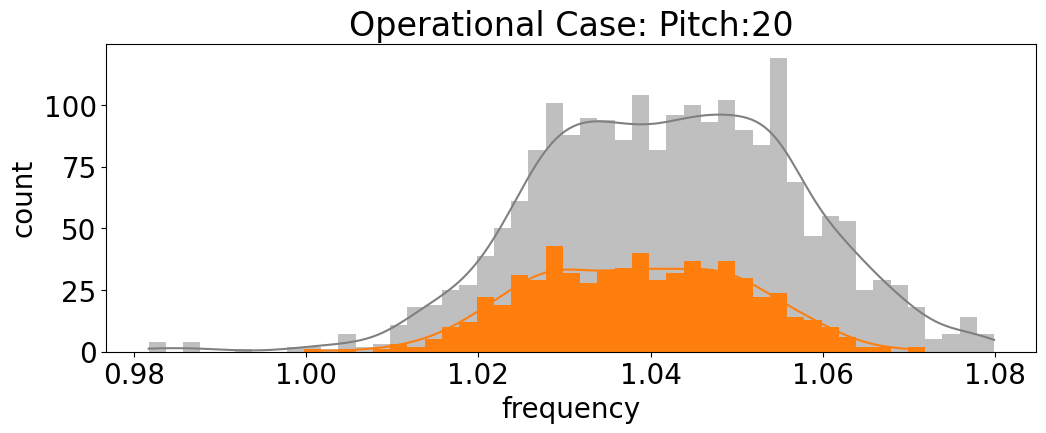

4.0 RPM<6.4


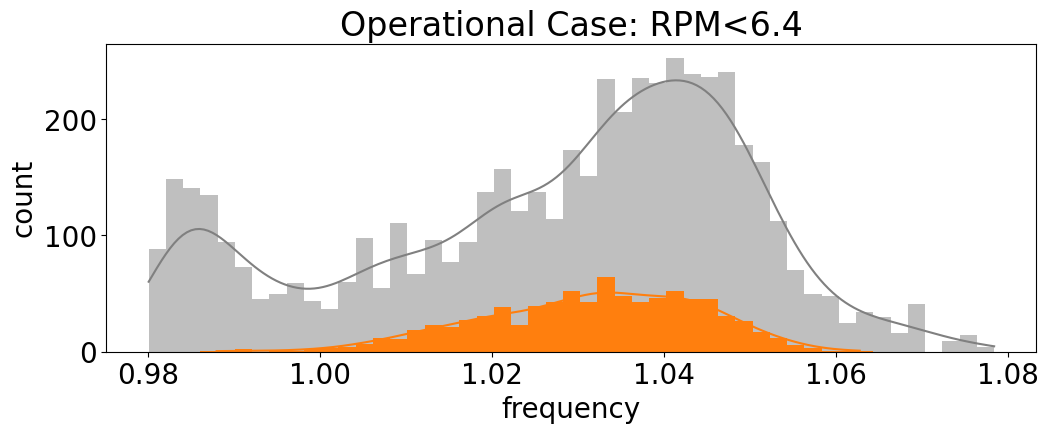

5.0 RPM:6.4


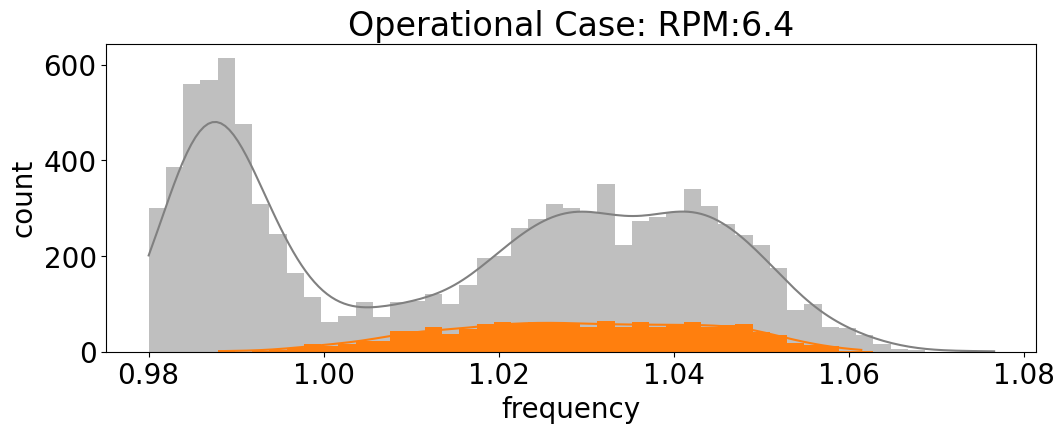

6.0 RPM<10


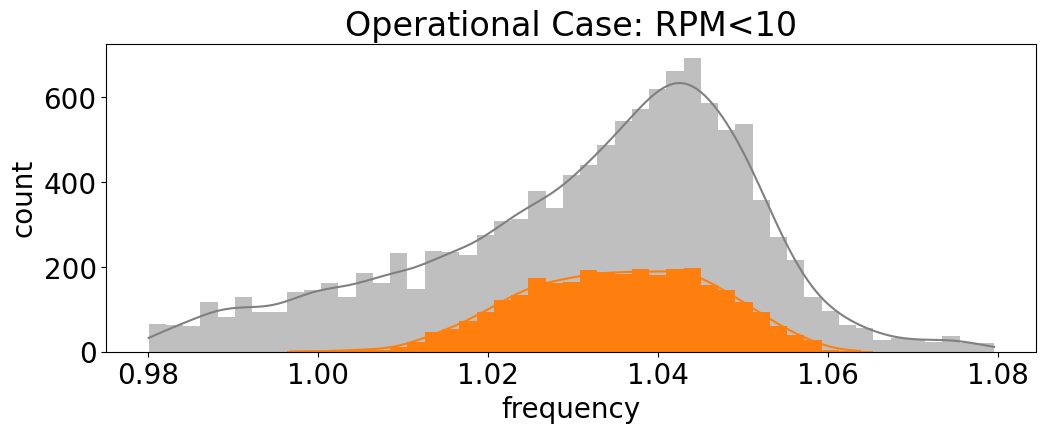

7.0 Rated RPM


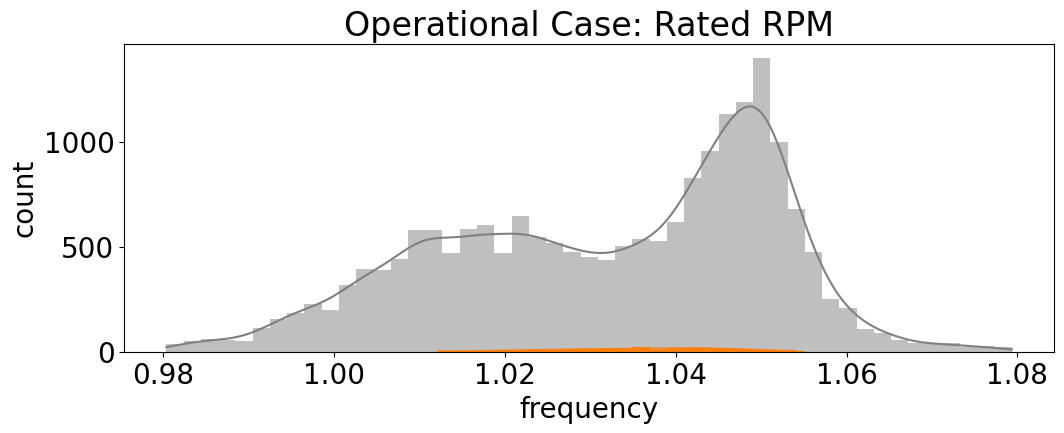

8.0 Rated Power


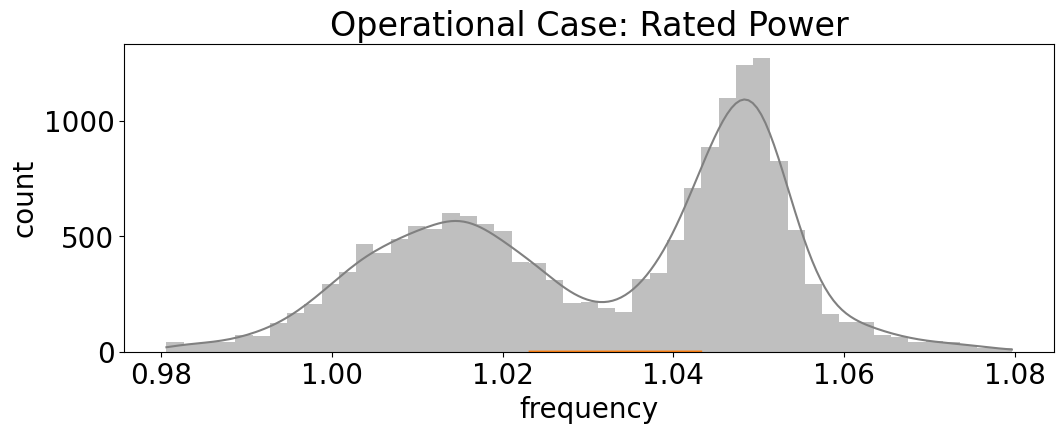

In [ ]:
for operational_case in np.sort(inputs['operational_case'].unique()):
    if not np.isnan(operational_case):
        
        print(operational_case, operaional_case_names[operational_case])
        case_indices = inputs[inputs['operational_case'] == operational_case].index
        smart_tracked_case_indices = smart_tracked_modes[smart_tracked_modes['frequency'].index.isin(case_indices)].index
        bins = np.linspace(mode_frequency_.loc[case_indices].min(), mode_frequency_.loc[case_indices].max(), 50)
        plt.figure(figsize=(12, 4))
        sns.histplot(y.loc[case_indices], kde=True, linewidth=0, color='grey', label='all data', common_norm=False, element='step', bins=bins, stat='count')
        sns.histplot(smart_tracked_modes.loc[smart_tracked_case_indices]['frequency'], kde=True, linewidth=0, color='tab:orange', label='smart tracked', common_norm=False, element='step', bins=bins, stat='count', alpha=1.0)
        #hist_all = plt.hist(mode_frequency_.loc[case_indices], label='all data', color='lightgrey', kde=True)
        #hist_smart = plt.hist(smart_tracked_modes.loc[smart_tracked_case_indices]['frequency'],  label='smart tracked', color='tab:orange', kde=True)
        plt.title('Operational Case: '+str(operaional_case_names[operational_case]))
        plt.ylabel('count')
        plt.xlabel('frequency')
        plt.show()
        plt.close()
